In [1]:
import os 
import random
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100


Ваша последняя лабораторная работа будет заключаться в реализации одного из двух алгоритмов, <br>подсказанных природой, для решении задачи vehicle routing problem:

1) Алгоритм колонии муравьев
2) Алгоритм колонии пчел

Данные:

Прикрепил в архиве. Формат такой:<br>
1-6 строчки - доп. информация про бенчмарку, No of trucks - количество грузовиков, CAPACITY - вместимость грузовика.<br>
7 строчка NODE_COORD_SECTION - начало данных про пункты<br>
1 17 36 - 1 пункт, координата по x - 17, координата по y - 36<br>
...<br>
Строчка DEMAND_SECTION - начало информации про требуемое количество материала для пункта<br>
7 9 - 7 пункт, 9 - требуемое количество материала. Если требуется 0 - этот пункт склад.<br>

Формат выходных данных, которые нужно выслать по каждой бенчмарке - приложил как файл B-n78-k10.sol в архиве.<br>

Дедлайн: 07.06.2020 23:59<br>

#### Ant
https://github.com/ustcldf/ACS-VRP <br>
https://github.com/afurculita/VehicleRoutingProblem/tree/master/src/ro/uaic/info/acs<br>
https://github.com/pkonowrocki/CVRP_ACO/blob/master/ACO_CVRP.py<br>
https://github.com/bsmdev/ant_colony<br>
#### Bee
https://github.com/JoyceWufm/Artificial-bee-colony-algorithm-for-vehicle-routing-problem/ <br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.457.8027&rep=rep1&type=pdf

In [1465]:
from utils import tools, visualize, common
problem = tools.get_problem('benchmarks/A/A-n44-k6.vrp')

n_trucks -> 6
optimal -> 937
capacity -> 100
n_locations -> 44
depot_i -> 0
demands -> [0.0, 8.0, 24.0, 9.0, 19.0, 9.0, 18.0, 9.0, 14.0, 3.0, 14.0, 8.0, 8.0, 13.0, 18.0, 4.0, 24.0, 14.0, 8.0, 18.0, 13.0, 2.0, 9.0, 18.0, 3.0, 24.0, 8.0, 24.0, 14.0, 13.0, 24.0, 23.0, 9.0, 13.0, 14.0, 14.0, 18.0, 24.0, 4.0, 8.0, 13.0, 4.0, 14.0, 18.0]


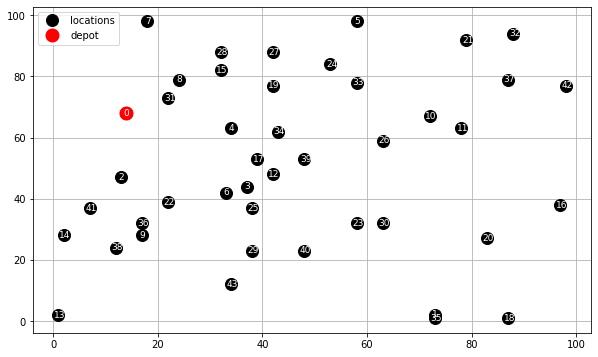

In [1466]:
tools     = imp.reload(tools)
visualize = imp.reload(visualize)
common    = imp.reload(common)

visualize.visualize_problem(problem)
for k, v in problem.items():
    if k !='locations' and k !='dists':
        print(k,"->", v)

In [1467]:
common   = imp.reload(common)
solution = common.generate_solution(problem, verbose=False)
print('Is feasible? {}'.format(common.check_solution(problem, solution, verbose=True)))
sol_cost = common.compute_solution(problem, solution)
print('Solution cost:', sol_cost)
solution

Route demand 101.0 exeeds capacity 100
Route  [93.0, 101.0, 106.0, 91.0, 95.0, 84.0]
Is feasible? False
Solution cost: 1795.6088


array([ 0,  2,  6,  4, 22, 31,  0, 34, 33, 39, 17,  8, 10, 16,  0, 35, 14,
        1, 41, 36, 13, 38,  9, 25,  0, 40, 23, 11, 24, 27, 32, 26, 12,  0,
       21,  5,  7, 15, 28, 19, 18, 29, 43,  0,  3, 30, 20, 37, 42,  0])

In [1483]:
from algorithm import bee_colony
bee_colony = imp.reload(bee_colony)

ABC = bee_colony.BeeColony(problem)
ABC.set_params(    n_epoch=200,
                   n_initials=30,
                   n_onlookers=6,
                   search_limit=problem['n_locations']
              )
%time abc_solution = ABC.solve()


Wall time: 59.8 s


In [1488]:
new_cost = common.compute_solution(problem, abc_solution)
print('Is feasible?',common.check_solution(problem, abc_solution, verbose=True))
print('Start cost: {}'.format(sol_cost))
print('ABC cost: {}'.format(new_cost))
print('Optimal cost: {}'.format(problem['optimal']))

Is feasible? True
Start cost: 1795.6087646484375
ABC cost: 1084.0645751953125
Optimal cost: 937


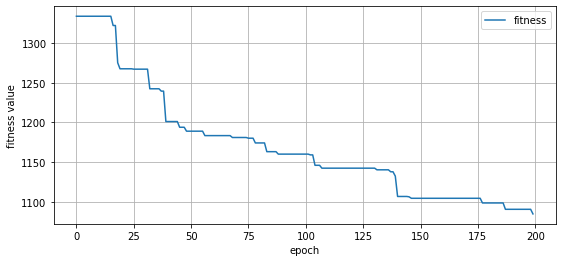

In [1489]:
visualize = imp.reload(visualize)
visualize.visualize_fitness(ABC.history)

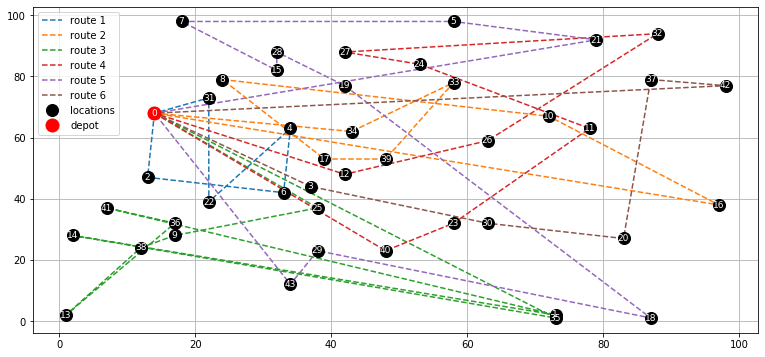

In [1490]:
visualize.visualize_problem(problem, solution, figsize=(13,6))

[24 10 11 21 42 16 20 26 34]
[27  5 32 37 33 19]
[22  9 38 13 14 41 36  2]
[43  1 35 18 30 23  3]
[ 8  7 28 15  4 39 12 17]
[ 6 29 40 25 31]


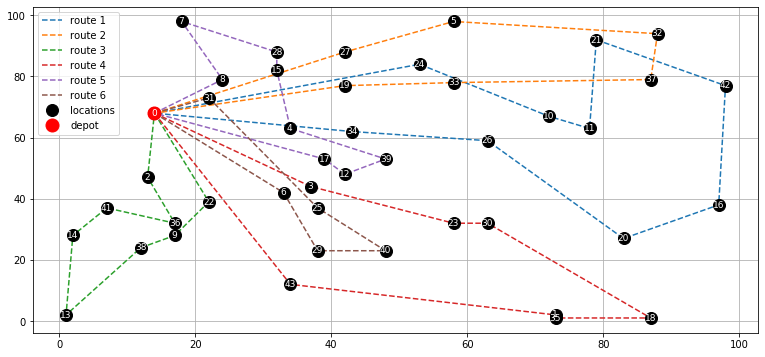

In [1491]:
visualize.visualize_problem(problem, abc_solution, figsize=(13,6))
depots = list(filter(lambda i: abc_solution[i]==0, range(len(abc_solution))))
for i, d in  enumerate(depots[:-1]):
    route = abc_solution[depots[i]+1:depots[i+1]]
    print(route)

In [1426]:
# from algorithm import local_search, neighbor_operator
# local_search = imp.reload(local_search)
# neighbor_operator = imp.reload(neighbor_operator)

# alg = local_search.LocalSearch(problem)
# alg.set_params(solution, n_iter=1000)
# %time new_sol, new_cost = alg.solve(verbose=True)
# print('Is feasible?',common.check_solution(problem, new_sol, verbose=True))
# new_cost

In [1430]:
# new_cost = common.compute_solution(problem, new_sol)
# print('Alg cost {}'.format(new_cost))
# print('Optimal cost {}'.format(problem['optimal']))
# new_sol